## 2.explore_nuclei segmentation

From `NucleiSegmentation_MIP_Dapi_Lamina` from Jenna's script: `/reading_czi_stack_videos_GH/imageAnalysis_jenna/HelperFunctionsforImageProcessing.py`

## Other Goals

- [ ] Stitch together videos from different areas. 
- [ ] Normalize for curvature? 
- [ ] Identify where on a zoomed out image the orginal was taken
- [ ] Get the time. 
- [ ] number each nuclei


In [2]:
import czifile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from skimage import filters, measure, segmentation, feature, img_as_ubyte, morphology
from scipy import ndimage as ndi
import pandas as pd

## Colors

from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

# Set up formatting for the movie files
# install: https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

## Set where image is displayed
%matplotlib inline 
%matplotlib notebook 
## %matplotlib qt 

In [3]:
## Read in example file
array = czifile.imread("/Users/samanthatang/Desktop/stack_data/dmel_st14__i_63x-04.czi")

## Use squeeze to get rid of channels my data doesnt have.
array = array.squeeze()

array.shape ## Check

(13, 2, 21, 928, 1389)

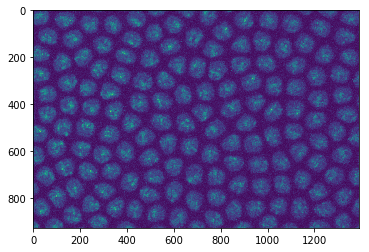

In [4]:
## Usining the colon, you can get all slices scanned and make a zstack
zstack = array[11, 1, :, ...]
zstack.shape

zstack_MAX= np.max(zstack, axis=0)
plt.imshow(zstack_MAX)
plt.show()

/Users/samanthatang/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


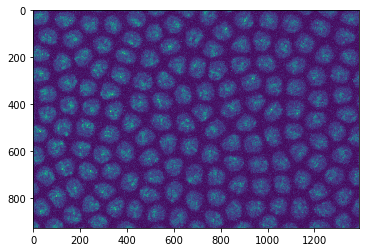

In [5]:
# Convert to 8bit
zstack_MAX_8bit = img_as_ubyte(zstack_MAX)
plt.figure()
plt.imshow(zstack_MAX_8bit)


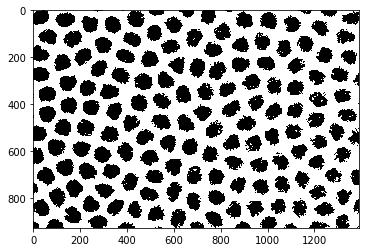

In [6]:
#### PART 1: Find centers with a conservative threshold
### First perform the conservative threshold on every point in the Z axis with the Otsu threshold
zstack_MAX_8bit_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 1) # blur image and remove noise

otsuthresh = filters.threshold_otsu(zstack_MAX_8bit_GausFilt) # grey scale 
zstack_MAX_8bit_GausFilt_localtheshold = zstack_MAX_8bit_GausFilt > otsuthresh

plt.figure()
plt.imshow(zstack_MAX_8bit_GausFilt_localtheshold, cmap = "Greys")

## Calling the Centers

- [Euclidean distance transform](https://medium.com/on-coding/euclidean-distance-transform-d37e06958216)

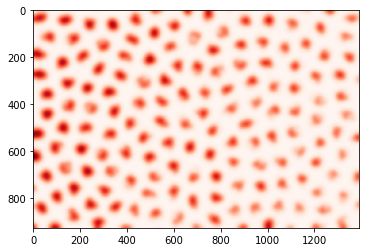

In [7]:
#### Then Call centers 
### Distance transform
distancetransform_combined_final = ndi.distance_transform_edt(zstack_MAX_8bit_GausFilt_localtheshold)

#### smoothen the distance transform
distancetransform_combined_final_gaus = ndi.filters.gaussian_filter(distancetransform_combined_final, 10)

plt.figure()
plt.imshow(distancetransform_combined_final_gaus, cmap = "Reds")

In [8]:
#### Retrieve the local maxima from the distance transform
## Gives a true false for every pixel if it is the max local peak?
Local_max = feature.peak_local_max(distancetransform_combined_final_gaus, indices = False, min_distance = 40)
Local_max_bigger = ndi.filters.maximum_filter(Local_max, size=20)

#makes a mask so that I can visualize on top of the original image
Local_max_mask = np.ma.array(Local_max_bigger, mask=Local_max_bigger==0)

#Add that mask back into the watershed image
CenterPointArrays = Local_max_bigger

In [9]:
#### PART 2: Now make a mask with a permissive threshold that goes all the way to the edges of the nuclei.
image_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 20)
localthresh = filters.threshold_local(image_GausFilt, 41)
image_GausFilt_localtheshold = image_GausFilt > localthresh
image_GausFilt_localtheshold_dilate = morphology.binary_dilation(image_GausFilt_localtheshold)
EdgeMask = image_GausFilt_localtheshold_dilate

#### Part 3: watershed
## Seperate objects
CenterPointArrays_items, num = ndi.label(CenterPointArrays)

## Watershed
watershed_image = morphology.watershed(~zstack_MAX_8bit_GausFilt, CenterPointArrays_items, mask = EdgeMask)

#### Part 4: Clear borders
Watershed_ClearBorders = segmentation.clear_border(watershed_image)

### Itemize
labeled_array_segmentation, num_features_seg = ndi.label(Local_max_mask)

## Don't understand how the CenterPointArrays is actually specifying points,
## I need to figure this out so I can assign nuclei identities

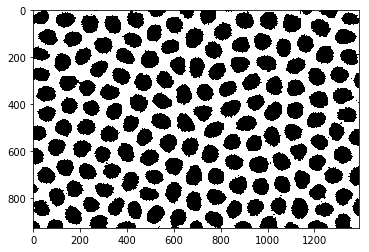

In [10]:
## EdgeMask Gaussian septerated. 
## Why not just do this instead of watershed?
EdgeMask_gauss = ndi.filters.gaussian_filter(EdgeMask, .5)
plt.figure()
plt.imshow(EdgeMask_gauss, "Greys")

## Visualize

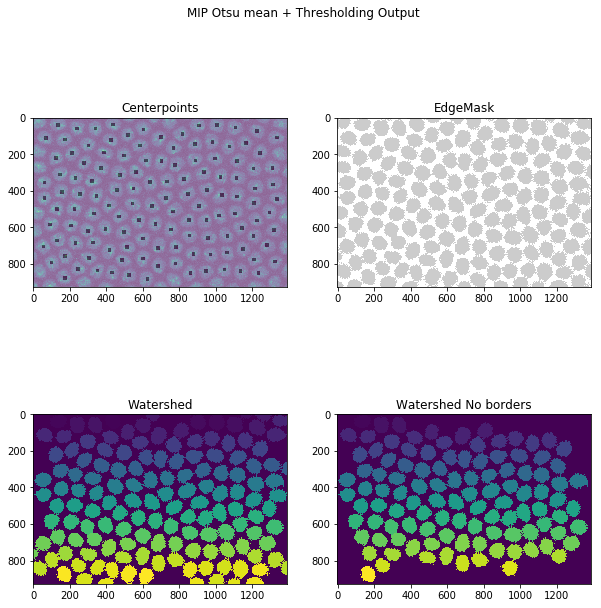

In [11]:

fig, axs = plt.subplots(nrows = 7, ncols = 5, figsize=(10, 10))
fig.suptitle('MIP Otsu mean + Thresholding Output')

plt.subplot(2,2,1)
plt.title('Centerpoints')
plt.imshow(zstack_MAX_8bit)
plt.imshow(CenterPointArrays,  cmap = 'Reds', alpha = 0.4)

plt.subplot(2,2,2)
plt.title('EdgeMask')
plt.imshow(EdgeMask, alpha = 0.2, cmap = 'Greys')

plt.subplot(2,2,3)
plt.title('Watershed')
plt.imshow(watershed_image)

plt.subplot(2,2,4)
plt.title('Watershed No borders')
plt.imshow(Watershed_ClearBorders)

### Next Step: Putting it all together

Now I want to put it all together so I can visualize 

- [x] Animate through all the maximum projections
- [ ] Do above on each z-stack
- [ ] Get tme incorporated


In [ ]:
## One thing to keep in mind is that the last scan is likely always less than total 
## We should drop the last z-stack = len(array)-1)

result_array =  np.zeros((1,928,1389))
type(result_array)

for i in range(1,len(array)-1):
    zstack_temp = array[i, 1, :, ...]
    result = np.expand_dims(np.max(zstack_temp, axis=0), axis = 0)
    result_array = np.append(result_array, result, axis = 0)

result_array = np.delete(result_array, 0, axis=0) # remove the empty starter array

np.shape(result_array)

In [ ]:
## go through each image in the z-stack
fig, ax = plt.subplots()
ax.axis('off') 
im = ax.imshow(result_array[1, :, :])

def update(i): # setting up the first image
    # Update method - What you want your figure to look like every single time
    im.set_array(result_array[i, :, :]) 
    return [im] #returned as a iterable object as a list.
    print(im)
    # frames is how long, by specifing how many images
    
movie = animation.FuncAnimation(fig, update, interval=300, frames=result_array.shape[0], blit=True)
plt.show()

## Adding them both together to create movie

This seems to work great.  A few points

1. The next step obviously would be to animate with the video. 
2. What do we do with the edge cases? What does the hernan lab do with them?
3. Smooth the edges so they are pretty.

Need to learn how to mess with colors:
https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

In [ ]:
## Read in example files


array1 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-02.czi")
array2 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-03.czi")
array3 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-04.czi")
array4 = czifile.imread("../data/2018-10-17/dmel_st14__i_63x-05.czi")

array = np.append(array1, array2, axis=2)
array = np.append(array, array3, axis=2)
array = np.append(array, array4, axis=2)

## Use squeeze to get rid of channels my data doesnt have.
array = array.squeeze()
np.shape(array)

In [ ]:
## Visualize full raw zstack
## One thing to keep in mind is that the last scan is likely always less than total 
## We should drop the last z-stack = len(array)-1)

result_array =  np.zeros((1,928,1389))
type(result_array)

for i in range(1,len(array)-1):
    zstack_temp = array[i, 1, :, ...]
    result = np.expand_dims(np.max(zstack_temp, axis=0), axis = 0)
    result_array = np.append(result_array, result, axis = 0)

result_array = np.delete(result_array, 0, axis=0) # remove the empty starter array

np.shape(result_array)

In [ ]:
## go through each image in the z-stack
fig, ax = plt.subplots()
ax.axis('off') 
im = ax.imshow(result_array[1, :, :])

def update(i): # setting up the first image
    # Update method - What you want your figure to look like every single time
    im.set_array(result_array[i, :, :]) 
    return [im] #returned as a iterable object as a list.
    print(im)
    # frames is how long, by specifing how many images
    
movie = animation.FuncAnimation(fig, update, interval=300, frames=result_array.shape[0], blit=True)
plt.show()

In [ ]:

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
im_ani = animation.FuncAnimation(fig, update, interval=100, frames=result_array.shape[0], blit=True)
im_ani.save('im.mp4', writer=writer)